In [31]:
import matplotlib.pyplot as plt
import math
import numpy as np

# Analytical Solution

Sc = 2.5
Sr = 0
Sig_ac = 0.066
Sig_ar = 0.02
Dc = 0.9
Dr = 0.18
a = 21.42

NuSigcf = 0.75
NuSigrf = 0

L_c = (Dc/Sig_ac)**(.5)
L_r = (Dr/Sig_ar)**(.5)

B = 0.0454
C2_2 = 1
C2_4 = C2_2*((L_r*Dc*B)/Dr)*((math.sin(B*a))/(math.cosh(a/L_r)))

x_c = np.linspace(0,a,100)
x_r = np.linspace(a,2*a,100)

def phi_maker(x, t):
    phi = np.zeros(len(x))
    for i in range(len(x)):
        if t == 'c':
             phi[i] = C2_2*math.cos(B*x[i])
        elif t == 'r':
            phi[i] = C2_4*math.sinh((2*a - x[i])/L_r)
        else:
            phi = 'please specify core or reflector'
            
    return phi

phi_core = phi_maker(x_c,'c')
phi_reflector = phi_maker(x_r,'r')

#print(phi_core)
#print(phi_reflector)

In [32]:
# Numerical Solution

def F_matrix(mesh):
    F = np.zeros((mesh,1), dtype=float)
    for i in range(mesh):
        if i< int(mesh/2):
            F[i,0] = NuSigcf
        else:
            F[i,0] = NuSigrf
    return F

def A_matrix(mesh,Sc,Sr,Sig_ac,Sig_ar,Dc,Dr,a):
    dx = 2*a/mesh
    A= np.zeros((mesh,mesh), dtype=float)
    diag_start = Dc/(dx**2) + Sig_ac
    diag_end = 3*Dr/(dx**2) + Sig_ar
    diagc = ((2*Dc)/(dx**2)) + Sig_ac
    diagr = ((2*Dr)/(dx**2)) + Sig_ar
    extrac = -Dc / (dx**2)
    extrar = -Dr / (dx**2)       
    for j in range(mesh):
        if j < int(mesh/2):
            A[j,j] = diagc
            A[j+1,j] = extrac
            A[j,j+1] = extrac
        if j >= int(mesh/2):
            if j == int(mesh-1):
                A[j,j] = diag_end
                continue
            A[j,j] = diagr
            A[j,j-1] = extrar
            A[j-1,j] = extrar
        if j == 0:
            A[j,j] = diag_start
    A[int(mesh/2 - 1),int(mesh/2)] = extrac
    return A

def phi_matrix(mesh,Sc,Sr,Sig_ac,Sig_ar,Dc,Dr,a):
    phi = 1
    k = 1
    s = F_matrix(mesh)*phi
    
    while True:
        so = s
        ko = k
        phi = np.linalg.solve(A_matrix(mesh,Sc,Sr,Sig_ac,Sig_ar,Dc,Dr,a),(so/ko))
        s = F_matrix(mesh)*phi
        k = ko*(sum(s)/sum(so))
        dk = k - ko
        if (dk < 0.0001) :
            break
    return phi/np.max(phi)

mesh_l = [10,20,40,80,160,320]
answer_l = []

for z in mesh_l:
    answer_l.append(phi_matrix(z,Sc,Sr,Sig_ac,Sig_ar,Dc,Dr,a))


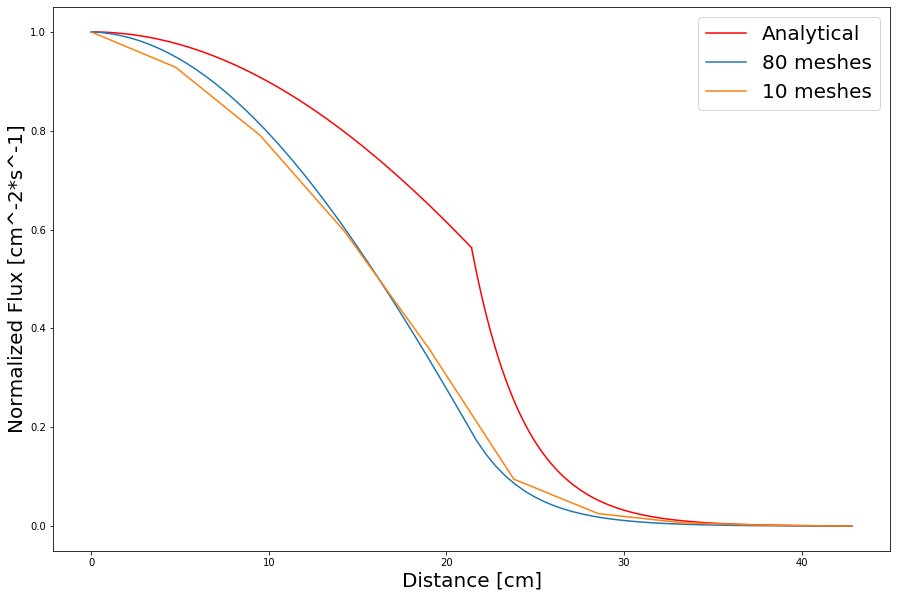

In [33]:
# Plot 10, 80 and Analytical
figure_1 = plt.figure(figsize = (15,10))
plt.xlabel('Distance [cm]' , fontsize = 20)
plt.ylabel('Normalized Flux [cm^-2*s^-1]' , fontsize = 20)
plt.plot(x_c,phi_maker(x_c, t='c'), color = 'red', label = 'Analytical')
plt.plot(x_r,phi_maker(x_r, t='r'), color = 'red')
plt.plot(np.linspace(0,2*a,80),phi_matrix(80,Sc,Sr,Sig_ac,Sig_ar,Dc,Dr,a), label = "80 meshes")
plt.plot(np.linspace(0,2*a,10),phi_matrix(10,Sc,Sr,Sig_ac,Sig_ar,Dc,Dr,a),label = "10 meshes")
#plt.title("Criticality Problem - Flux vs Distance (Part A)")
plt.legend(loc = "upper right",prop={'size': 20})
plt.show()

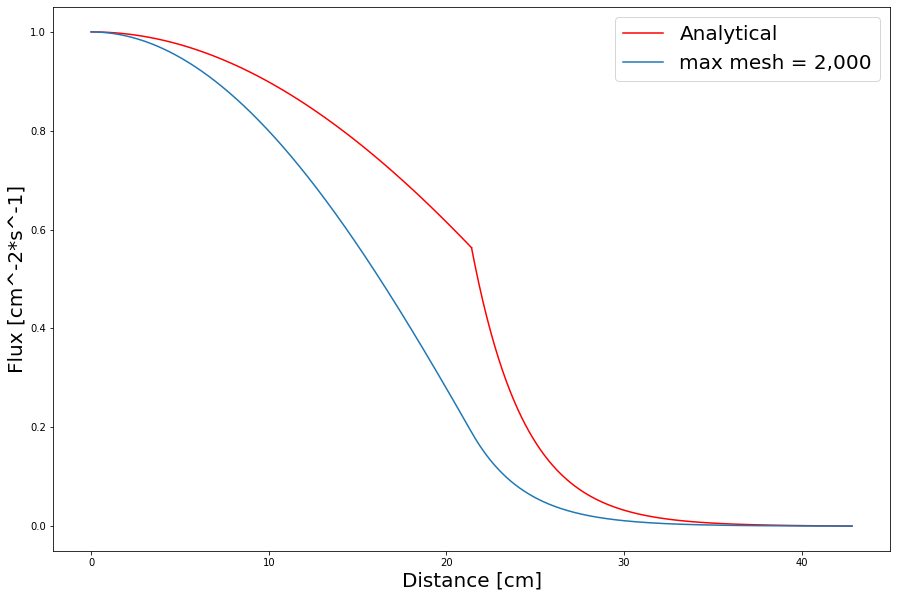

In [34]:
# Plot Max Mesh and Analytical

figure_2 = plt.figure(figsize = (15,10))
plt.xlabel('Distance [cm]' , fontsize = 20)
plt.ylabel('Flux [cm^-2*s^-1]' , fontsize = 20)
plt.plot(x_c,phi_maker(x_c, t='c'), color = 'red', label = 'Analytical')
plt.plot(x_r,phi_maker(x_r, t='r'), color = 'red')

for i in [2000]:
    plt.plot(np.linspace(0,2*a,i),phi_matrix(i,Sc,Sr,Sig_ac,Sig_ar,Dc,Dr,a), label = "max mesh = 2,000")
#plt.title("Criticality Problem - Flux vs Distance (Part B)")
plt.legend(loc = "upper right",prop={'size': 20})
plt.show()

In [35]:
# Numerical and Analytic Solution Convergence Behaviour
from tabulate import tabulate

x = np.concatenate((x_c,x_r), axis = 0)
phi = np.concatenate((phi_maker(x_c, t='c'),phi_maker(x_r, t='r')), axis=0)

phi_center_analytic = phi[99]
phi_centers = []
for z in mesh_l:
    index = int(z/2 - 1)
    matrix = phi_matrix(z,Sc,Sr,Sig_ac,Sig_ar,Dc,Dr,a)
    phi_centers.append(float(phi_matrix(z,Sc,Sr,Sig_ac,Sig_ar,Dc,Dr,a)[index]))

def percent_error_calc(a,b):
    return abs(a-b)/a * 100

error = []
for i in range(len(phi_centers)):
    error.append(percent_error_calc(phi_center_analytic,phi_centers[i]))

print(tabulate([[10, phi[99], phi_centers[5],error[5]], [20,phi[99],phi_centers[4],error[4]],[40,phi[99],phi_centers[3],error[3]],[80,phi[99],phi_centers[2],error[2] ],[160,phi[99],phi_centers[1],error[1] ],[320,phi[99],phi_centers[0],error[0] ]], headers=['Meshes', 'Analytical Flux [cm^-2*s^-1]', 'Numerical Flux [cm^-2*s^-1]', 'Percentage Error %']))

  Meshes    Analytical Flux [cm^-2*s^-1]    Numerical Flux [cm^-2*s^-1]    Percentage Error %
--------  ------------------------------  -----------------------------  --------------------
      10                        0.563262                       0.194127               65.5351
      20                        0.563262                       0.198486               64.7613
      40                        0.563262                       0.207443               63.1711
      80                        0.563262                       0.226281               59.8267
     160                        0.563262                       0.267241               52.5548
     320                        0.563262                       0.35817                36.4114
